In [102]:
# ML_in_Finance-RNNs-Coinbase
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

## An Introduction to Prediction with RNNs

### Overview
- This notebook provides an example of how TensorFlow can be used to train and test a RNNs for time series prediction. The example dataset is for predicting from noisy non-stationarity data.
- Statistical methods used for autoregressive models shall be used to identify the sequence length needed in the RNN and to diagnose the model error.
- Plain RNNs are not suited to non-stationary time series modeling. We can use a GRU or LSTM to model non-stationarity data, since these models exhibit dynamic auto-correlation structure.
- Unlike classical time series methods, e.g. ARIMA, there are no parameteric assumptions on the distribution of the errors, and non-linear relationships between response and predictors can be captured without over-fitting. 
- The data is one minute snapshots of the USD value of coinbase over 2018.

#### Statistician's note
- We choose to build a model which provides strong predictive power, in favor of explantory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' -identifying the relevant features to include in the model. 
- In this tutorial, we assume that we've already identifed the relevant set of features (i.e. there is only one time series provided).
- Our primary concern in assessing the extent to which the model is over-fitting by comparing the in and out-of-sample MSEs.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

Import the necessary set of modules from Keras

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.models import load_model

Using TensorFlow backend.


### Example Data
- The example dataset is a chronologically ordered time series. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- Each observation $X$ has one variable (a.k.a. univariate time series).

Loading the Pandas Dataframe, viewing the first ten rows and the distribution of the labels:

In [5]:
df = pd.read_csv('coinbase.csv', index_col=[1])

In [6]:
df.head()

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931


# RNN Regression
We consider a univariate prediction problem where the time series is given by 'USD' in the data frame.

In [7]:
use_features = ['USD'] # continuous input
target = 'USD' # continuous output

### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostics tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the computation time of the test.

In [8]:
df=df.fillna(method="backfill")

In [9]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df[use_features[0]][:200000].values)

In [10]:
print(adf,p, nobs, cvs)

Here we accept the null as the p-value is larger than 0.01, thus we can not reject the test at the 99% confidence level. This suggests that the time series is non-stationary.

#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\tau_h:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1}):=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
$$ 
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where T is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimat the PACF. The 'nlags' parameter is the maximum number of lags used for PACF estimation.

In [11]:
pacf=sm.tsa.stattools.pacf(df[use_features], nlags=30)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [12]:
n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df[use_features])))==False)[0][0] -1

In [13]:
print(n_steps)

4


This may lead to a high order model, with more lags than strictly necessary. We could view this value, informally, as an upper bound on the number of lags needed. We can also simply identify the order of the model based on the plot of the PACF. In this case, a minimum of 4 lags appears satisfactory, although more may be needed. Unlike autoregressive models, the advantage of using fewer parameters is purely computational as adding more lags does not increase the number of parameters, only the size of the tensorial representation of the sequence data in TensorFlow. 

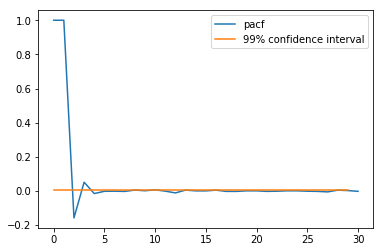

In [14]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(len(df[use_features]))]*30, label='99% confidence interval (lower)')
plt.legend()

Split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [15]:
train_weight = 0.8
split = int(len(df)*train_weight)
df_train = df.iloc[:split]

### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [16]:
mu = np.float(df_train[use_features].mean())
sigma = np.float(df_train[use_features].std())

In [17]:
std_df_train = df_train[use_features].apply(lambda x: (x - mu) / sigma)

In [18]:
df_test = df.iloc[split:]
std_df_test = df[use_features].apply(lambda x: (x - mu) / sigma).iloc[split:]

### Data formatting for RNNs

TensorFlow uses tensors to represent data. To perform sequence learning, the time series of variables must be transformed to a series of over-lapping sub-sequences. 

For example, consider a univariate time series of increasing integers.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, for example, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15


Let's define the following function for reshaping the data into one-step ahead times series prediction format. 

In [19]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

We shall first transform the training input and output data.

In [54]:
x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(std_df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

In [55]:
col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

In [56]:
x_train_reg = x_train_reg.iloc[:, col_ords]

In [57]:
y_train_reg = std_df_train.loc[x_train_reg.index, [target]].values

In [58]:
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

Now repeat the transformation on the test data.

In [59]:
x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(std_df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

In [60]:
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = std_df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

Print the shapes of each tensor. The first digit is the number of observations. For feature arrays, the second digit is the sequence length (i.e. the number of lags in the model) and the final digit is the dimension of each element in the sequence or output vector respectively. In this case, the example performs univariate time series analysis and so the dimension of the input and output is 1.

In [61]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(361340, 4, 1) (361340, 1) (90333, 4, 1) (90453, 1)


### Model Specification

Let's configure and fit a GRU to our univariate data

In [62]:
x_train_reg.shape[1], x_train_reg.shape[-1], n_steps

(4, 1, 4)

In [63]:
n_hidden=5

In [64]:
reg_model = Sequential()
reg_model.add(GRU(n_hidden, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
reg_model.add(Dense(1))
reg_model.compile(loss='mean_squared_error', optimizer='adam')

Use a batch size of 500 as the dataset is reasonably large and the training time would be too long otherwise. 20 epoches have been used here, but a better approach would be to use a stopping criteria through a call back. 

In [67]:
reg_model.fit(x_train_reg, y_train_reg, epochs=20, batch_size=500, verbose=1)

Epoch 1/20
361340/361340 [==============================] - 4s 10us/step - loss: 0.1263
Epoch 2/20
361340/361340 [==============================] - 3s 9us/step - loss: 0.0061
Epoch 3/20
361340/361340 [==============================] - 3s 9us/step - loss: 9.5674e-04
Epoch 4/20
361340/361340 [==============================] - 3s 9us/step - loss: 3.3892e-04
Epoch 5/20
361340/361340 [==============================] - 3s 9us/step - loss: 1.9223e-04
Epoch 6/20
361340/361340 [==============================] - 3s 9us/step - loss: 1.2591e-04
Epoch 7/20
361340/361340 [==============================] - 3s 10us/step - loss: 8.6676e-05
Epoch 8/20
361340/361340 [==============================] - 3s 9us/step - loss: 6.1618e-05
Epoch 9/20
361340/361340 [==============================] - 4s 10us/step - loss: 4.7542e-05
Epoch 10/20
361340/361340 [==============================] - 3s 9us/step - loss: 4.0996e-05
Epoch 11/20
361340/361340 [==============================] - 3s 8us/step - loss: 3.9525e-05
Ep

In [32]:
# optionally save the fitted model
#reg_model.save('model/gru_regression_coinbase.hdf5', overwrite=True)  # creates a HDF5 file 'my_model.h5'

In [33]:
# optionally load a fitted model if this file exists.
#reg_model = load_model('model/gru_regression_coinbase.hdf5')

#### Comparison with plain RNNs
For comparison, let us compare the performance of the GRU with the plain RNN.

In [68]:
sreg_model = Sequential()
sreg_model.add(SimpleRNN(n_hidden, input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1])))
sreg_model.add(Dense(1))
sreg_model.compile(loss='mean_squared_error', optimizer='adam')

In [69]:
sreg_model.fit(x_train_reg, y_train_reg, epochs=20, batch_size=500, verbose=1)

Epoch 1/20
361340/361340 [==============================] - 2s 5us/step - loss: 0.7324
Epoch 2/20
361340/361340 [==============================] - 1s 4us/step - loss: 0.0248
Epoch 3/20
361340/361340 [==============================] - 2s 4us/step - loss: 0.0048
Epoch 4/20
361340/361340 [==============================] - 2s 4us/step - loss: 0.0014
Epoch 5/20
361340/361340 [==============================] - 2s 4us/step - loss: 5.3739e-04
Epoch 6/20
361340/361340 [==============================] - 2s 4us/step - loss: 2.9619e-04
Epoch 7/20
361340/361340 [==============================] - 2s 4us/step - loss: 2.1478e-04
Epoch 8/20
361340/361340 [==============================] - 1s 4us/step - loss: 1.7322e-04
Epoch 9/20
361340/361340 [==============================] - 2s 4us/step - loss: 1.4654e-04
Epoch 10/20
361340/361340 [==============================] - 2s 4us/step - loss: 1.2760e-04
Epoch 11/20
361340/361340 [==============================] - 1s 4us/step - loss: 1.1352e-04
Epoch 12/20
3

### Prediction

We shall now apply the fitted RNN model to the training set and the test set, separately. We can then informally assess the extent
of over-fitting.

Make predictions with the trained GRU

In [70]:
pred_train = reg_model.predict(x_train_reg, verbose=1)
pred_test = reg_model.predict(x_test_reg, verbose=1)

90333/90333 [==============================] - 2s 26us/step


Let us compare with the plain RNN

In [71]:
s_pred_train = sreg_model.predict(x_train_reg, verbose=1)
s_pred_test = sreg_model.predict(x_test_reg, verbose=1)

90333/90333 [==============================] - 2s 17us/step


### Model Performance

Text(0,0.5,'Y')

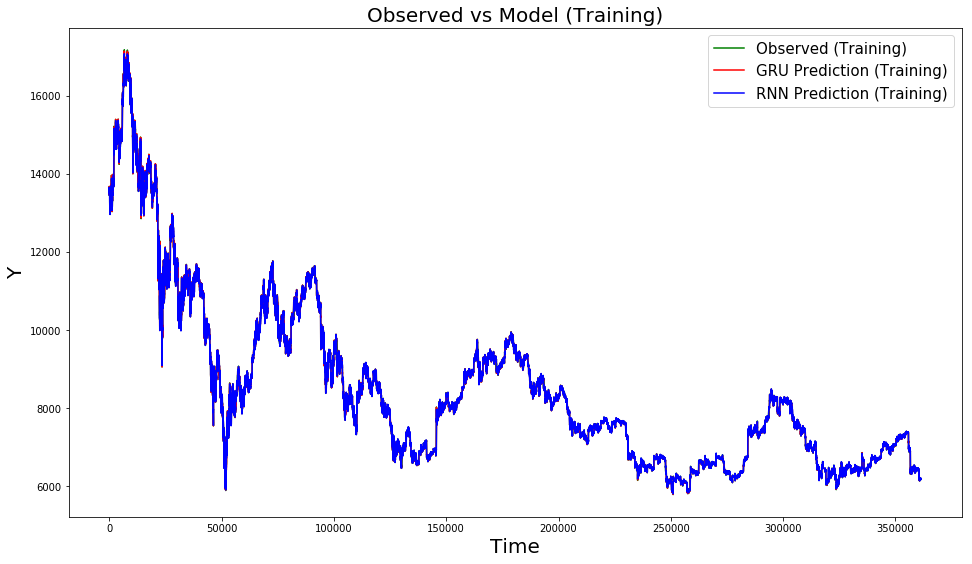

In [82]:
fig = plt.figure(figsize=(16,9))
train_line_real = plt.plot(df_train[use_feature][n_steps:].values, color="g", label="Observed (Training)")
train_line_pred = plt.plot(sigma*pred_train[:, 0]+mu, color="r", label="GRU Prediction (Training)")
train_line_pred = plt.plot(sigma*s_pred_train[:, 0]+mu, color="b", label="RNN Prediction (Training)")

plt.legend(loc="best", fontsize=15)
plt.title('Observed vs Model (Training)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

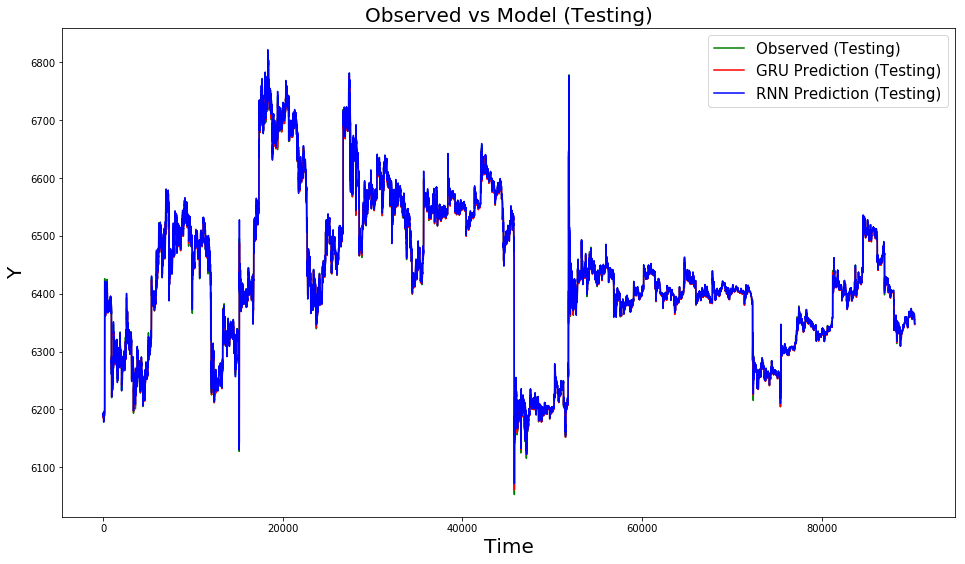

In [81]:
fig = plt.figure(figsize=(16,9))
test_line_real = plt.plot(df_test[use_feature][n_steps:].values, color="g", label="Observed (Testing)")
test_line_pred = plt.plot(sigma*pred_test[:, 0]+mu, color="r", label="GRU Prediction (Testing)")
test_line_pred = plt.plot(sigma*s_pred_test[:, 0]+mu, color="b", label="RNN Prediction (Testing)")

plt.legend(loc="best", fontsize=15)
plt.title('Observed vs Model (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

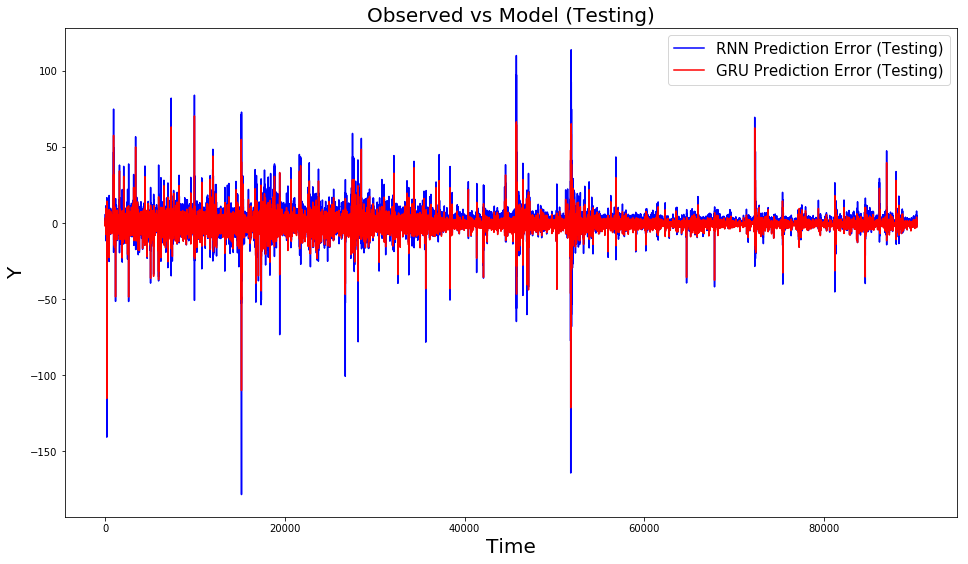

In [84]:
fig = plt.figure(figsize=(16,9))
test_line_pred = plt.plot(sigma*s_pred_test[:, 0]+mu - df_test[use_feature][n_steps:].values, color="b", label="RNN Prediction Error (Testing)")

test_line_pred = plt.plot(sigma*pred_test[:, 0]+mu - df_test[use_feature][n_steps:].values, color="r", label="GRU Prediction Error (Testing)")

plt.legend(loc="best", fontsize=15)
plt.title('Observed vs Model (Testing)', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

We observe the in-sample prediction is reliable (upper plot). Most of the out-of-sample prediction (lower plot) is also reliable although the end of the predicted sequence appears to degrade. Such a degradation indicates the prediction horizon might be too long and the model should be retrained.

Finally assess the performance of the model in and out-of-sample using the MSE. We expect the mean error to be larger on the test set than on the training set. 

In [76]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:].values, sigma*pred_train[:, 0]+mu)
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:].values, sigma*pred_test[:, 0]+mu)
print(MSE_test)

144.33129183983246
9.979952728289078


In [77]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:].values, sigma*s_pred_train[:, 0]+mu)
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:].values, sigma*s_pred_test[:, 0]+mu)
print(MSE_test)

290.06039735559864
25.267422847977528


### Model Diagnostics

A fitted time series model must be examined for underfitting with a white noise test. We analyze the model residuals (i.e. the error $u_t$) to determine whether it is white noise or whether it is auto-correlated. The latter case provides statistical evidence that more lags are needed in the RNN. Box and Pierce propose the Portmanteau statistic:

$$Q^*(m)=T\sum_{l=1}^m\hat{\tau}_l^2,$$

as a test statistic for the null hypothesis $$H_0:\tau_1=\dots=\tau_m=0$$ against the alternative hypothesis $$H_a:\tau_i\neq 0$$ for some $$i\in\{1,\dots,m\}$$, where $T$ is the number of observations, $\hat{\tau}_i$ are the sample autocorrelations of the residual, and $m$ is the maximum lag used in the test. There are several heuristics in the statistics literature to determine the maximum lag such as the Schwert statistic. 

The Box-Pierce statistic follows an asymptotically chi-squared distribution with $m$ degrees of freedom.

The Ljung-Box test statistic increases the power of the test in finite samples:
$$Q(m)=T(T+2)\sum_{l=1}^m\frac{\hat{\tau}_l^2}{T-l}$$.

This statistic also follows an asymptotically chi-squared distribution with $m$ degrees of freedom. The decision rule is to reject $H_0$ if $Q(m)>\chi_{\alpha}^2$ where $\chi_{\alpha}^2$ denotes the $100(1-\alpha)^{th}$ percentile of a chi-squared distribution with m degrees of freedom and is the significance level for rejecting $H_0$.

The test can be time consuming and we select a subset of the residuals. Here we simply set the maximum lag to 20. In the results below, we find that the p-values are all smaller than 0.01, indicating that we can reject the null at the 99% confidence level for any lag. This is strong evidence that the model is under-fitting and more lags are needed in our model. Unlike an auto-regressive model, increasing the number of lags in the RNN does not increase the number of weights. Thus there is no danger of over-fitting by increasing the lag, although there will be an increase in the training time.

In [97]:
T=100000

In [98]:
residual=df_train[use_feature][n_steps:(n_steps+T)].values-(sigma*pred_train[:T, 0]+mu)

In [99]:
lb,p=sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False)

The Box-Ljung test statistics are

In [100]:
lb

array([17145.79470896, 17175.19795798, 17253.24855096, 17314.11952185,
       17398.53486084, 17453.94200507, 17458.58977022, 17458.86007284,
       17459.12506354, 17487.48212127, 17611.68797122, 17635.65544221,
       17637.7658394 , 17637.88988689, 17640.91371593, 17668.61017841,
       17707.4052102 , 17728.21403799, 17741.87293566, 17765.9719557 ])

The p-values are

In [101]:
p

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])